# EDA of Correlations within Data

In [98]:
import h5py

import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('../histograms.mplstyle')

import scipy.stats
import scipy.optimize

from matplotlib.ticker import ScalarFormatter, MultipleLocator, FormatStrFormatter, AutoMinorLocator

In [20]:
PLOT_PATH   = "./plots/"
PLOT_PREFIX = "correlations_"
PLOT_EXT    = ".png"

## Brief data inspection

In [17]:
# path to data file
FILE_NAME = "../data/RUN0000541_channels.h5"

# get keys
f = h5py.File(FILE_NAME, "r")
keys = f.keys()

# build the dataset by concatenating all channels together
df = pd.concat(
    [
        pd.read_hdf(FILE_NAME, key=k, mode="r") for k in keys
    ],
    ignore_index=True
)

# rename columns
df = df.rename(columns={"CH":"ch", "HIT_DRIFT_TIME":"drift_time", "THETA":"theta", "D_WIRE_HIT":"d_wire"})

print(f"Shape: {df.shape}")
print(f'Features: {list(df.columns)}')

Shape: (1059979, 5)
Features: ['ch', 'drift_time', 'd_wire', 'm', 'theta']


### Visualization

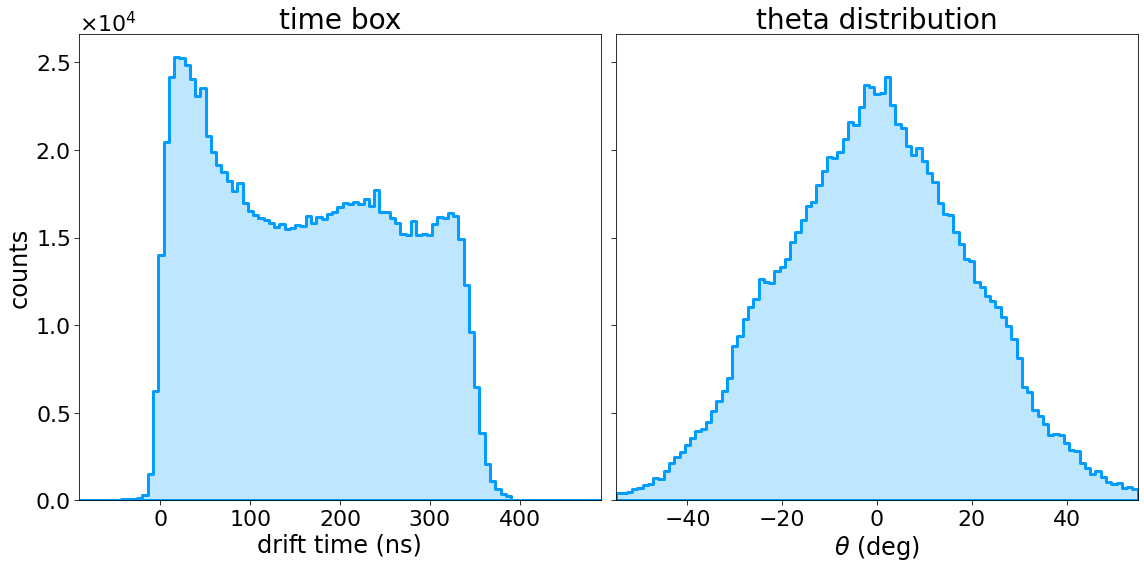

In [88]:
# BINS:
# drift time
dt_bins    = np.linspace(-90, 490, 100)
# theta
theta_bins = np.linspace(-55, 55 ,100)

fig, ax = plt.subplots(ncols=2, figsize=(16,8), sharey=True)

ax[0].set_title("time box")
ax[0].set_xlabel("drift time (ns)")
ax[0].set_ylabel("counts")

ax[1].set_title("theta distribution")
ax[1].set_xlabel(r"$\theta$ (deg)")
# ax[1].set_ylabel("density")

ax[0].set_xlim(dt_bins[0], dt_bins[-1])
ax[1].set_xlim(theta_bins[0], theta_bins[-1])

# drift time distribution
sns.histplot(
    x         = df.drift_time,
    bins      = dt_bins,
    stat      = "count",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 3,
    label     = "full dataset",
    ax        = ax[0]
)

# theta distribution
sns.histplot(
    x         = df.theta,
    bins      = theta_bins,
    stat      = "count",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 3,
    label     = "full dataset",
    ax        = ax[1]
)

# exponential y ticks
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[0].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax[0].yaxis.get_offset_text().set_fontsize(22)

ax[1].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[1].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax[1].yaxis.get_offset_text().set_fontsize(22)

ax[0].tick_params(axis="both", which="major", labelsize=22, length=5)
ax[1].tick_params(axis="both", which="major", labelsize=22, length=5)


fig.tight_layout()
PLOT_NAME = "distributions"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

### Scatterplot and Correlation coefficient

In [66]:
def plot_full_scatter(df, features):
    """scatterplot and profile plot of two features"""
    
    # perform a linear regression using scipy.stats.linregress
    reg_results = scipy.stats.linregress(df[features[0]], df[features[1]])

    # bin the x data
    bins = np.linspace(-200, 400, 12)
    # we add a column to our dataframe so we can use pandas.DataFrame.groupby()
    df["bin"] = np.digitize(df[features[0]], bins=bins)

    # bin centers
    x    = 0.5 * (bins[1:] + bins[:-1])
    # mean of y data inside each bin
    y    = df.groupby("bin")[features[1]].mean()
    # std of y data inside each bin
    erry = df.groupby("bin")[features[1]].std()
    
    xgrid = np.linspace(df[features[0]].min(), df[features[0]].max(), 300)
    
    fig, ax = plt.subplots(figsize=(14,8))
    
    ax.set_xlim(dt_bins[0], dt_bins[-1])
    ax.set_ylim(theta_bins[0], theta_bins[-1])
    
    ax.set_title("scatter theta vs drift time", fontsize=28)
    ax.set_xlabel("drift time (ns)", fontsize=24)
    ax.set_ylabel("theta (deg)", fontsize=24)
    
    ax.tick_params(axis="both", which="major", labelsize=22, length=5)
    

    ax.scatter(
        data      = df,
        x         = features[0],
        y         = features[1],
        color     = "#aadeff",
        edgecolor = "#009cff",
        alpha     = 0.7,
        label="data points"
    )
    
    ax.errorbar(
        x, 
        y, 
        yerr=erry, 
        color="black",
        ecolor ="black", 
        elinewidth=2,
        capsize=2,
        capthick=2,
        marker="o", 
        linestyle="",
        alpha=1,
        label = "profile", 
    )
    
    ax.plot(
        xgrid,    
        reg_results.intercept + reg_results.slope*xgrid, 
        color = "#ff6300", 
        linestyle = "dashed", 
        linewidth = 3, 
        label="regression"
    )
    
    ax.legend(loc="lower left", fontsize=24, bbox_to_anchor=(1, 0.5))
    df.drop(labels="bin", axis=1, inplace=True)
    
    return fig, ax

Correlation coefficient between drift time and theta: -0.02869
p-value = 8.180e-192
Statistically significant: YES


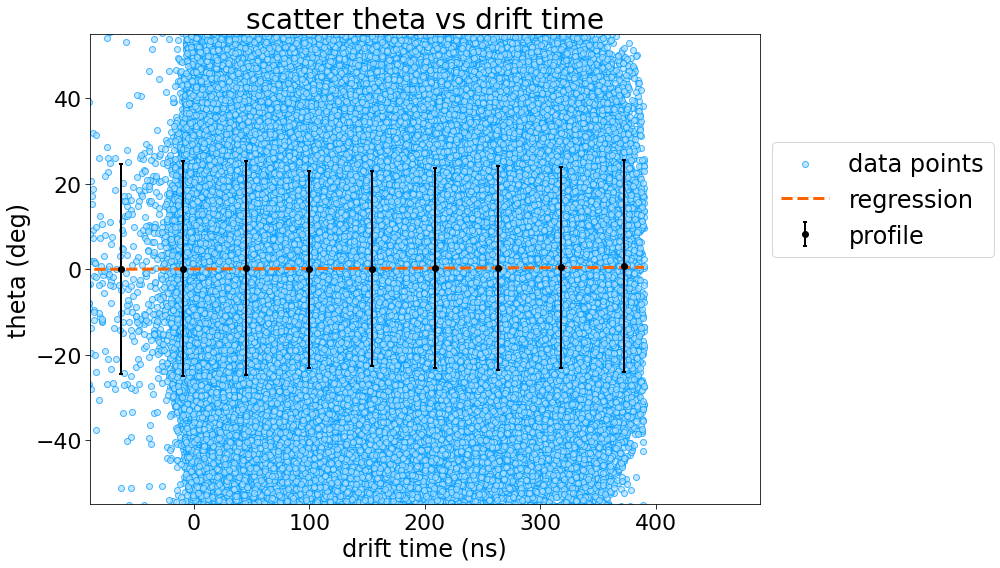

In [69]:
# correlation coefficient and its p-value
# note that I'm considering the absolute value of the angular feature:
# due to its simmetry I believe that we can get more statistical significance if we do so
r, p = scipy.stats.pearsonr(df.drift_time, np.abs(df.theta))
# set a confidence level at 5%
alpha = 0.05

print(f"Correlation coefficient between drift time and theta: {r:.5f}")
print(f"p-value = {p:.3e}")
print("Statistically significant:", "YES" if p < alpha else "NO")

fig, ax = plot_full_scatter(df=df, features=["drift_time", "theta"])
fig.tight_layout()
PLOT_NAME = "scatter"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)
plt.show()

### Covariance matrix

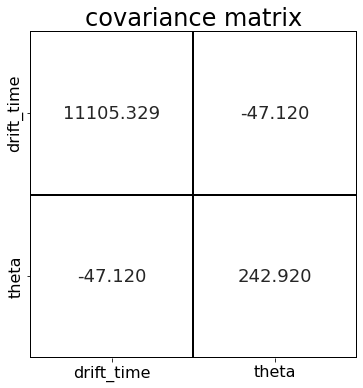

In [6]:
# covariance matrix
# note that I'm still considering the absolute value of theta
cov = np.cov([df.drift_time, np.abs(df.theta)])

textcolors = ["white", "black"]
ticklabels = ["drift_time","theta"]

fig, ax = plt.subplots(figsize=(6,6)) 
ax.set_title("covariance matrix")        

# plot of the covariance matrix
sns.heatmap(
    data        = cov,
    cmap        = ["white"],
    linecolor   = "black",
    linewidth   = 2,
    xticklabels = ticklabels, 
    yticklabels = ticklabels,
    robust      = True,
    annot       = True,
    fmt         = ".3f",
    annot_kws   = {"fontsize":18},
    cbar        = False,
    square      = True,
    ax          = ax
)

plt.show()

## Cutting the angular feature

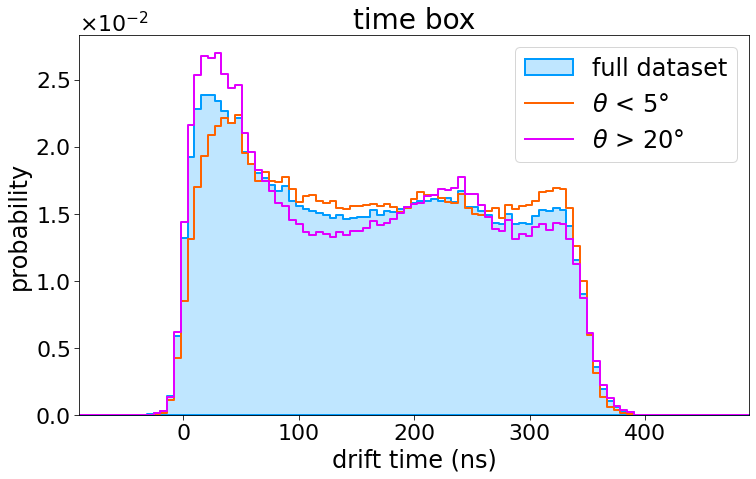

In [71]:
# binning drift time
bins = np.linspace(-90, 490, 100)
binwidth = bins[1] - bins[0]
bincenters = 0.5 * (bins[1:]+bins[:-1])

# CUTS:
# theta lower than |5°|
cut_1 = np.abs(df.theta) < 5
# theta higher than |20°|
cut_2 = np.abs(df.theta) > 20


fig, ax = plt.subplots(figsize=(12,7))

ax.set_title("time box", fontsize=28)
ax.set_xlabel("drift time (ns)", fontsize=24)
ax.set_ylabel("probability", fontsize=24)        # using probability instead of density

ax.set_xlim(bins[0], bins[-1])


# full dataset - drift time distribution
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "#009cff",
    linewidth = 2,
    label     = "full dataset",
    ax        = ax
)

# theta lower than |5°| - drift time distribution
sns.histplot(
    x         = df[cut_1].drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = False,
    color     = "#ff6300",
    linewidth = 2,
    label     = r"$\theta$ < 5°",
    ax        = ax
)

# theta higher than |20°| - drift time distribution
sns.histplot(
    x         = df[cut_2].drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = False,
    color     = "#e200ff",
    linewidth = 2,
    label     = r"$\theta$ > 20°",
    ax        = ax
)



# exponential y ticks
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax.yaxis.get_offset_text().set_fontsize(22)
ax.tick_params(axis="both", which="major", labelsize=22, length=5)



ax.legend(fontsize=24)

PLOT_NAME = "simple_cut"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

## Possible breakthrough: correlation with cuts

In [106]:
def normalize(hist):
    """normalizes an histogram such that the sum of bin heights is equal to 1

    Args:
        hist      (np.ndarray): bin heights
        
    Return:
        norm_hist (np.ndarray): normalized bin heights
    """
    return (hist / np.sum(hist))

In [107]:
# list of selected values of theta 
thetas = np.arange(5, 55, 5)

# create a list of masks (cuts) that slices data if theta is less than the selected value
low_cuts = [
    np.abs(df.theta) < theta for theta in thetas
]
# create a list of masks (cuts) that slices data if theta is higher than the selected value
high_cuts = [
    np.abs(df.theta) > theta for theta in thetas
]

In [108]:
# bin the time box for each (low) cut value 
hists         = [np.histogram(df[cut].drift_time, bins=bins)[0] for cut in low_cuts]
low_hist_bins = [np.histogram( df[cut].drift_time, bins=bins )[1] for cut in low_cuts ]

low_norms     = [np.sum(h) for h in hists]
low_hists     = [normalize(h) for h in hists]
low_err       = [np.sqrt(h/n) for h,n in zip(low_hists,low_norms)]
# find the maximum of the left edge peak 
low_peaks     = [h.max() for h in low_hists]
low_peaks_err = [e.max() for e in low_err]      # HORRIBLE WAY TO SELECT THE CORRESPONDING UNCERTAINTY

# bin the time box for each (high) cut value 
hists          = [np.histogram(df[cut].drift_time, bins=bins)[0] for cut in high_cuts]
high_hist_bins = [np.histogram( df[cut].drift_time, bins=bins )[1] for cut in high_cuts ]

high_norms     = [np.sum(h) for h in hists]
high_hists     = [normalize(h) for h in hists]
high_err       = [np.sqrt(h/n) for h,n in zip(high_hists,high_norms)]
# find the maximum of the left edge peak 
high_peaks     = [h.max() for h in high_hists]
high_peaks_err = [e.max() for e in high_err]    # HORRIBLE WAY TO SELECT THE CORRESPONDING UNCERTAINTY



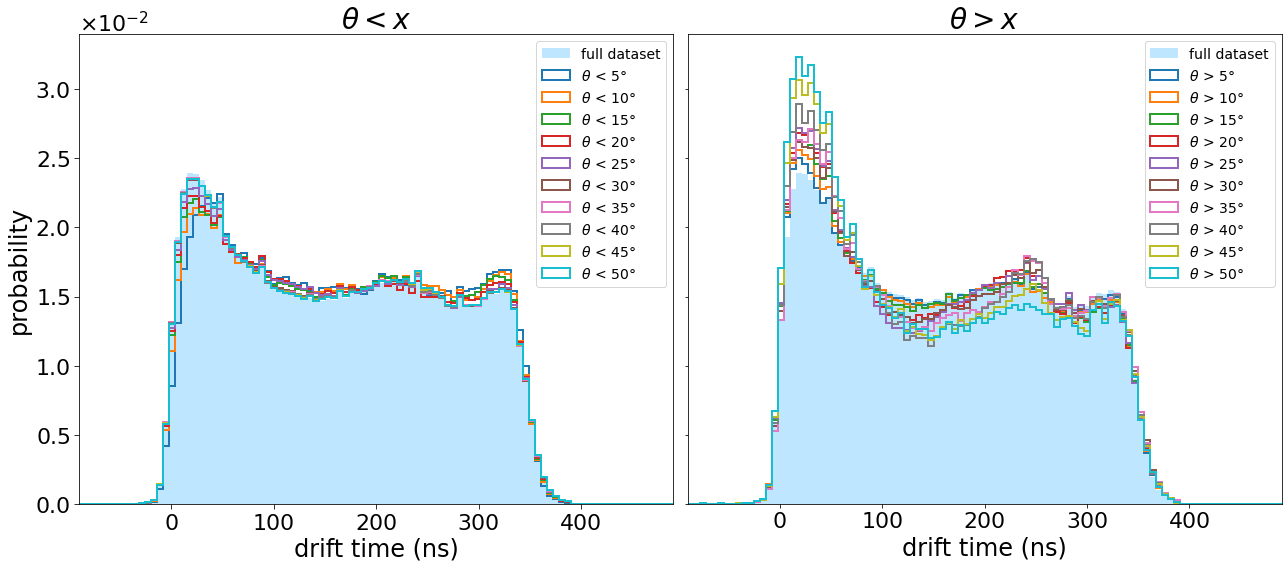

In [109]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(18,8))


ax[0].set_title(r"$\theta < x$")
ax[0].set_xlabel("drift time (ns)")
ax[0].set_ylabel("probability")
ax[1].set_title(r"$\theta > x$")
ax[1].set_xlabel("drift time (ns)")

# exponential y ticks
ax[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax[0].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax[0].yaxis.get_offset_text().set_fontsize(22)
ax[0].tick_params(axis="both", which="major", labelsize=22, length=5)


# x range
ax[0].set_xlim(bins[0], bins[-1])

# ------------------------------------
# FULL DATASETS FOR REFERENCE
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "none",
    label     = "full dataset",
    ax        = ax[0]
)
sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "none",
    label     = "full dataset",
    ax        = ax[1]
)
# ------------------------------------

# low-cut time boxes
for h, theta in zip(low_hists, thetas):
    ax[0].hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        linewidth = 2,
        label=r"$\theta$ < "+str(theta)+"°"
    )

# high-cut time boxes
for h, theta in zip(high_hists, thetas):
    ax[1].hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        linewidth = 2,
        label=r"$\theta$ > "+str(theta)+"°"
    )


ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

fig.tight_layout()

PLOT_NAME = "timebox_shape"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.show()

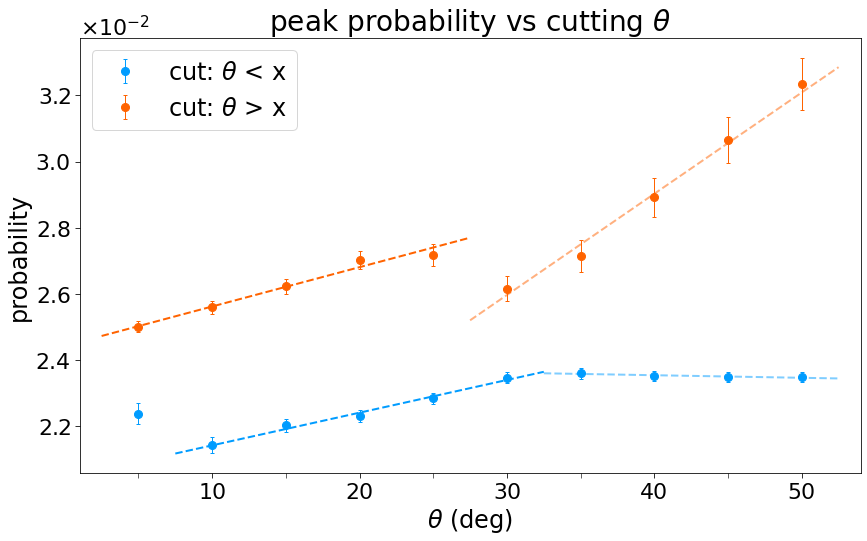


LOW CUT:
Correlation coefficient (small theta) 0.99317
p-value = 6.77e-04
Statistically significant: YES
Correlation coefficient (large theta) -0.95306
p-value = 4.69e-02
Statistically significant: YES

HIGH CUT:
Correlation coefficient (small theta) 0.98644
p-value = 1.89e-03
Statistically significant: YES
Correlation coefficient (large theta) 0.99575
p-value = 3.32e-04
Statistically significant: YES


In [101]:
# linear function
def lin(x, a, b): return a + b*x

# x grid for theta values (continuous, employed in plotting the fitted function)
theta_grid = np.linspace(thetas[0]-4, thetas[-1]+4, 500)

# fitting low cuts
low_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[1:6], 
    ydata=low_peaks[1:6],
    sigma=low_peaks_err[1:6], 
    absolute_sigma=True
)

# fitting high cuts
high_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[0:5], 
    ydata=high_peaks[0:5],
    sigma=high_peaks_err[0:5], 
    absolute_sigma=True
)

# TO DO: perform goodness-of-fit test (easy chi2 test)

fig, ax = plt.subplots(figsize=(14,8))

ax.set_title(r"peak probability vs cutting $\theta$", fontsize=28)
ax.set_xlabel(r"$\theta$ (deg)", fontsize=24)
ax.set_ylabel("probability", fontsize=24)

ax.set_xlim(theta_grid[0], theta_grid[-1])
# ax.set_ylim(0.01,0.039)


# exponential y ticks
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax.yaxis.get_offset_text().set_fontsize(22)
ax.tick_params(axis="both", which="major", labelsize=22, length=5)

ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(axis="x", which="minor", labelsize=0, length=5)


# low-cut scatter
ax.errorbar(
    x          = thetas, 
    y          = low_peaks,
    yerr       = low_peaks_err,
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ < x"
)
# low-cut fit
ax.plot(
    np.linspace(thetas[1]-2.5, thetas[5]+2.5, 100), 
    lin(np.linspace(thetas[1]-2.5, thetas[5]+2.5, 100), *low_par),
    linestyle = "dashed",
    color = "#009cff", 
    lw=2
)

# high-cut scatter
ax.errorbar(
    x          = thetas, 
    y          = high_peaks,
    yerr       = high_peaks_err,
    marker     = "o",
    markersize = 8,
    color      =  "#ff6300",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ > x"
)
# high-cut fit
ax.plot(
    np.linspace(thetas[0]-2.5, thetas[4]+2.5, 100), 
    lin(np.linspace(thetas[0]-2.5, thetas[4]+2.5, 100), *high_par),
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2
)

# fitting low cuts
low_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[6:], 
    ydata=low_peaks[6:],
    sigma=low_peaks_err[6:], 
    absolute_sigma=True
)

# fitting high cuts
high_par, _ = scipy.optimize.curve_fit(
    f=lin,
    xdata=thetas[5:], 
    ydata=high_peaks[5:],
    sigma=high_peaks_err[5:], 
    absolute_sigma=True
)

# low-cut fit
ax.plot(
    np.linspace(thetas[6]-2.5, thetas[-1]+2.5, 100), 
    lin(np.linspace(thetas[6]-2.5, thetas[-1]+2.5, 100), *low_par),
    linestyle = "dashed",
    color = "#009cff", 
    lw=2,
    alpha=0.5,
)
# high-cut fit
ax.plot(
    np.linspace(thetas[5]-2.5, thetas[-1]+2.5, 100), 
    lin(np.linspace(thetas[5]-2.5, thetas[-1]+2.5, 100), *high_par),
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2,
    alpha=0.5,
)

PLOT_NAME = "cut_fit"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)

plt.legend(fontsize=24)
plt.show()


# -------- CORRELATION COEFFICIENTS
# set a confidence level at 5%
alpha = 0.05

# compute correlation coefficients
low_small_r,   low_small_p = scipy.stats.pearsonr(thetas[1:6], low_peaks[1:6])
low_large_r,   low_large_p = scipy.stats.pearsonr(thetas[6:], low_peaks[6:])

high_small_r, high_small_p = scipy.stats.pearsonr(thetas[0:5], high_peaks[0:5])
high_large_r, high_large_p = scipy.stats.pearsonr(thetas[5:], high_peaks[5:])

print("\nLOW CUT:")
print(f"Correlation coefficient (small theta) {low_small_r:.5f}")
print(f"p-value = {low_small_p:.2e}")
print("Statistically significant:", "YES" if low_small_p < alpha else "NO")
print(f"Correlation coefficient (large theta) {low_large_r:.5f}")
print(f"p-value = {low_large_p:.2e}")
print("Statistically significant:", "YES" if low_large_p < alpha else "NO")

print("\nHIGH CUT:")
print(f"Correlation coefficient (small theta) {high_small_r:.5f}")
print(f"p-value = {high_small_p:.2e}")
print("Statistically significant:", "YES" if high_small_p < alpha else "NO")
print(f"Correlation coefficient (large theta) {high_large_r:.5f}")
print(f"p-value = {high_large_p:.2e}")
print("Statistically significant:", "YES" if high_large_p < alpha else "NO")

# Intervalli $\theta_{low} < \theta_i < \theta_{up}$

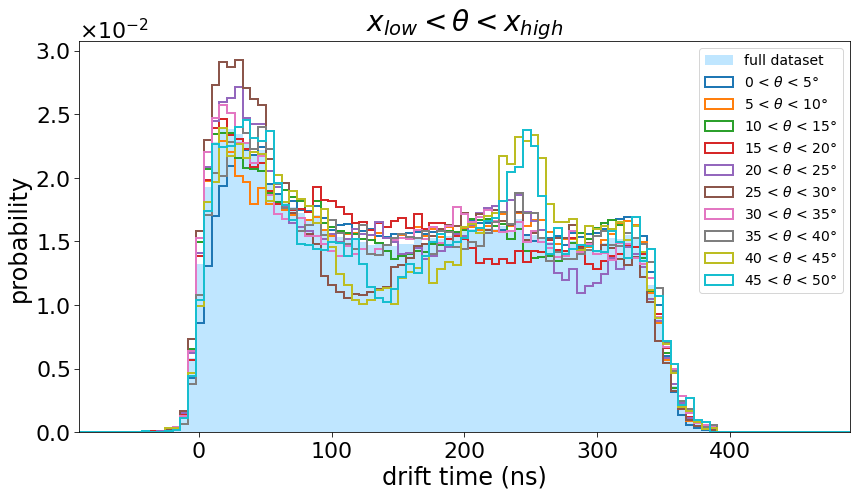

In [113]:
thetas_low = np.arange(0,50,5)
thetas_up = np.arange(5,55,5)
bins = np.linspace(-90,490,100)

middle_cut = [ ( (np.abs(df["theta"]) > low ) & (np.abs(df["theta"]) < up ) ) for low, up in zip(thetas_low,thetas_up) ]

middle_hist      = [np.histogram( df[cut].drift_time, bins=bins )[0] for cut in middle_cut ]
middle_hist_bins = [np.histogram( df[cut].drift_time, bins=bins )[1] for cut in middle_cut ]

middle_norm_hist = [normalize(h) for h in middle_hist]
middle_norm      = [np.sum(h) for h in middle_hist]
middle_err       = [np.sqrt(h/ n) for h,n in zip(middle_norm_hist, middle_norm)]
middle_peaks     = [h.max() for h in middle_norm_hist]
middle_peaks_err = [e.max() for e in middle_err]

fig, ax = plt.subplots(figsize=(12,7))

# x range
ax.set_xlim(bins[0], bins[-1])

ax.set_title(r"$x_{low} < \theta < x_{high}$", fontsize=28)
ax.set_xlabel("drift time (ns)", fontsize=24)
ax.set_ylabel("probability", fontsize=24)


# exponential y ticks
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax.yaxis.get_offset_text().set_fontsize(22)
ax.tick_params(axis="both", which="major", labelsize=22, length=5)

sns.histplot(
    x         = df.drift_time,
    bins      = bins,
    stat      = "probability",
    element   = "step",
    fill      = True,
    color     = "#aadeff",
    edgecolor = "none",
    label     = "full dataset",
    linewidth = 3,
    ax        = ax
)

# middle-cut time boxes
for h, theta_low, theta_up in zip(middle_norm_hist, thetas_low,thetas_up,):
    ax.hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        linewidth = 2,
        label=str(theta_low)+" "+ r"< $\theta$ < "+str(theta_up)+"°"
    )
    
ax.legend(fontsize = 14)

fig.tight_layout()
PLOT_NAME = "cut_intervals"
fig.savefig(PLOT_PATH+PLOT_PREFIX+PLOT_NAME+PLOT_EXT, dpi=300)
plt.show()

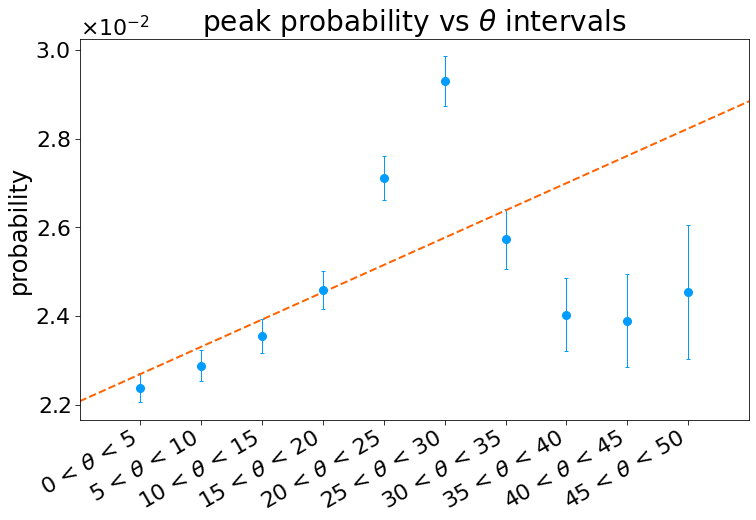

In [138]:
from scipy.optimize import curve_fit

def lin(x, A, B): return A + B*x

thetas_low = np.arange(0,50,5)
thetas_up = np.arange(5,55,5)
x_theta = np.linspace(-5,50,500)


xlabels = [r"%i < $\theta$ < %i"%(x1,x2) for x1, x2 in zip(thetas_low,thetas_up)]

middle_par_tot, _ = curve_fit(
    f     = lin,
    xdata = thetas_low,
    ydata = middle_peaks,
    sigma = middle_peaks_err,
    )

fig, ax = plt.subplots(figsize=(12,7))

ax.set_title(r"peak probability vs $\theta$ intervals")
ax.set_ylabel("probability")
ax.set_xticklabels(xlabels, rotation=30, ha="right")
ax.set_xticks(thetas_low)

ax.set_xlim(x_theta[0], x_theta[-1])

ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
ax.yaxis.get_offset_text().set_fontsize(22)
ax.tick_params(axis="both", which="major", labelsize=22, length=5)

ax.errorbar(
    x=thetas_low, 
    y=middle_peaks, 
    yerr=middle_peaks_err,
    marker     = "o",
    markersize = 8,
    color      = "#009cff",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2
)

ax.plot(
    x_theta, 
    lin(x_theta, *middle_par_tot), 
    linestyle = "dashed",
    color =  "#ff6300",
    lw = 2,
    alpha=1,
)


plt.show()

In [15]:
# -------- CORRELATION COEFFICIENTS
# set a confidence level at 5%
alpha = 0.05

# compute correlation coefficients
middle_r,   middle_p = scipy.stats.pearsonr(xdata, middle_peaks)

print("\nmiddle CUT:")
print(f"Correlation coefficient {middle_r:.5f}")
print(f"p-value = {middle_p:.2e}")
print("Statistically significant:", "YES" if middle_p < alpha else "NO")



middle CUT:
Correlation coefficient 0.19297
p-value = 5.93e-01
Statistically significant: NO


In [16]:
# -------- CORRELATION COEFFICIENTS
# set a confidence level at 5%
alpha = 0.05

# compute correlation coefficients
middle_r,   middle_p = scipy.stats.pearsonr(xdata_min, middle_peaks[:4])

print("\nmiddle CUT:")
print(f"Correlation coefficient {middle_r:.5f}")
print(f"p-value = {middle_p:.2e}")
print("Statistically significant:", "YES" if middle_p < alpha else "NO")



middle CUT:
Correlation coefficient 0.99909
p-value = 9.12e-04
Statistically significant: YES


In [17]:
from scipy.optimize import curve_fit

def lorentzian(x, A, x0, gamma):
    return A*gamma**2/(gamma**2+(x-x0)**2)

def gaussian(x, A , mean , std ):
    return A * np.exp( - ((x - mean) **2 /(2*std**2)))

x=np.linspace(0,100, 35)
bins = np.linspace(-90, 490, 100)
xx=np.linspace(x[0], x[-1], 1000)

# stima picchi con gauss

0.02231 pm 0.00013
0.02306 pm 0.00011
0.02280 pm 0.00011
0.02414 pm 0.00009
0.02393 pm 0.00010


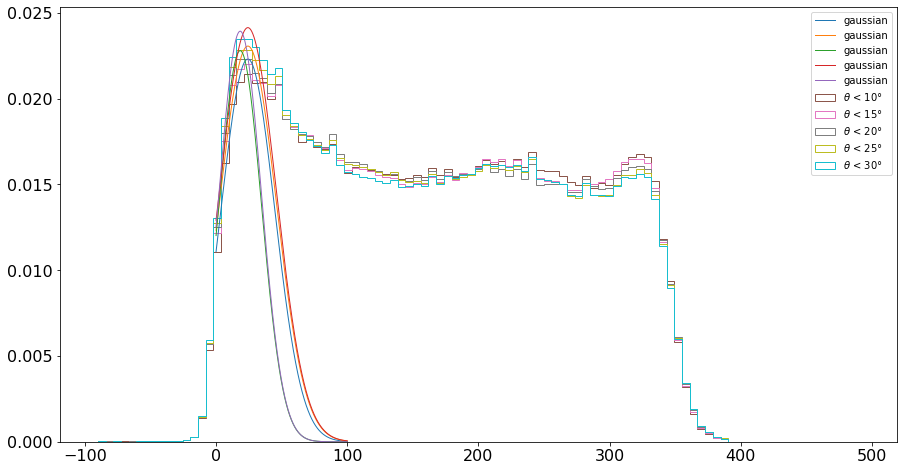

In [24]:
fig, ax = plt.subplots(figsize=(15,8))

gauss_low_peaks = []
lor_low_peaks = []
low_params=[]
gauss_low_err = []

# for cut in low_cuts:
#     df_prova = df[ cut ]
#     p, b = np.histogram(df_prova.drift_time, bins=bins)
#     p_norm = normalize(p)
#     bin_centers = (b[1:]+b[:-1])/2

#     #incertezze sulle y cioè sulle probabilità:
#     norm = sum(p)
#     err = [np.sqrt(h / norm) for h in p_norm] #errore su tutti i p

#     DF = pd.DataFrame({'prob':p_norm, 'bin_cent':bin_centers, 'err':err})
#     DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
#     DF = DF.reset_index(drop=True)

for p,b,err in zip(low_hists, low_hist_bins, low_err ):
    
    bin_centers = (b[1:]+b[:-1])/2

    DF = pd.DataFrame({'prob':p, 'bin_cent':bin_centers, 'err':err})
    DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
    DF = DF.reset_index(drop=True)

    prob_peak = DF['prob'].max()
    bin_peak = DF['bin_cent'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]
    err_peak = DF['err'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]

    first_half_df = DF.loc[DF['bin_cent'] < bin_peak]
    prob_first_half =  first_half_df['prob']
    err_first_half = first_half_df['err']

    bin_cent = DF['bin_cent'][(len(first_half_df)+1) : (2*len(first_half_df) +1) ].reset_index(drop=True)

    second_half_df = pd.concat([prob_first_half, bin_cent, err_first_half], axis=1, ignore_index=True)
    second_half_df.columns = ['prob', 'bin_cent', 'err']
    second_half_df['prob'] = second_half_df['prob'].values[::-1]
    second_half_df['err'] = second_half_df['err'].values[::-1]

    first_half_df = first_half_df.append({'prob':prob_peak, 'bin_cent':bin_peak, 'err':err_peak}, ignore_index=True)
    final_df = first_half_df.append(second_half_df, ignore_index=True)
    final_df = final_df.dropna(axis=0)
    
    popt_gauss, covar = curve_fit(gaussian, final_df['bin_cent'], final_df['prob'], 
    p0=[ prob_peak , bin_peak, 10], 
    sigma=final_df['err'], 
    absolute_sigma=True
    )
    # popt_lor, _ = curve_fit(lorentzian, final_df['bin_cent'], final_df['prob'], p0=[0.02, 20, 10])

    y_gauss = gaussian(xx,*popt_gauss)
    gauss_low_peaks.append( y_gauss.max() )

    sigma = np.sqrt(np.diagonal(covar)) #array con i 3 errori sui 3 parametri stimati da curve fit
    #di questi prendiamo solo il primo errore che è quello commesso sullo scale parameter (picco)
    gauss_low_err.append(sigma[0])
    ax.plot(xx, gaussian(xx,*popt_gauss), linewidth=1, label='gaussian')

for h, theta in zip(low_hists, thetas):
    ax.hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        label=r"$\theta$ < "+str(theta)+"°"
    )
    
ax.legend()

for p,e in zip(gauss_low_peaks, gauss_low_err):
    print(f'{p:.5f} pm {e:.5f}')


Correlation coefficient 0.88551
p-value = 4.57e-02
Statistically significant: YES


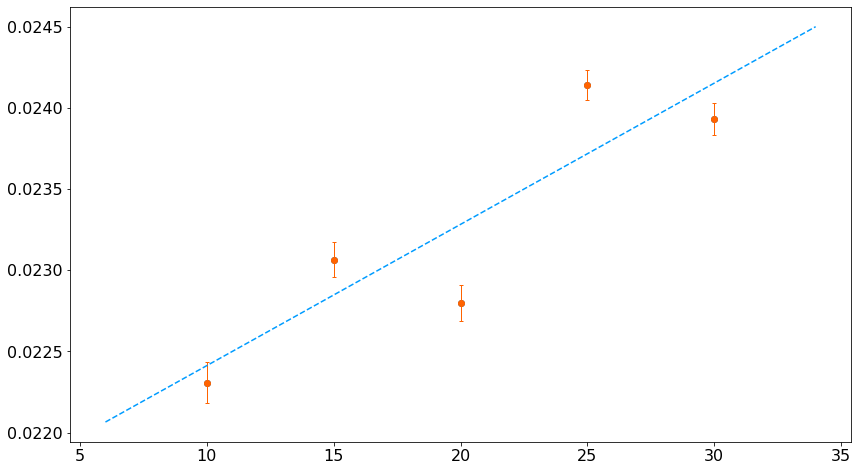

In [25]:
gauss_par, _ = curve_fit(
    f=lin,
    xdata=thetas, 
    ydata=gauss_low_peaks,
    sigma=gauss_low_err,
    absolute_sigma=True
)

fig, ax = plt.subplots()

theta_grid = np.linspace(thetas[0]-4, thetas[-1]+4, 500)
# ax.set_xlim(theta_grid[0], theta_grid[-1])

ax.scatter(
    thetas, gauss_low_peaks
)
ax.plot(
    theta_grid, 
    lin(theta_grid, *gauss_par),
    linestyle = "dashed",
    color = "#009cff", 
)
ax.errorbar(
    x          = thetas, 
    y          = gauss_low_peaks,
    yerr       = gauss_low_err,
    marker     = "o",
    color      =  "#ff6300",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ > x"
)

high_r, high_p = scipy.stats.pearsonr(thetas, gauss_low_peaks)
# high_r, high_p = scipy.stats.pearsonr(thetas, gauss_up_peaks)

print(f"Correlation coefficient {high_r:.5f}")
print(f"p-value = {high_p:.2e}")
print("Statistically significant:", "YES" if high_p < alpha else "NO")

# Taglio sopra

0.02630 pm 0.00012
0.02684 pm 0.00014
0.02874 pm 0.00013
0.02779 pm 0.00019
0.02694 pm 0.00024


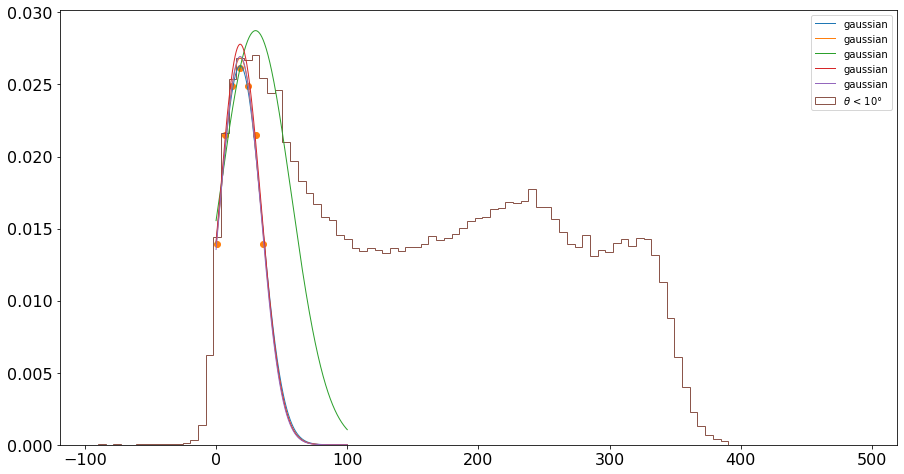

In [26]:
fig, ax = plt.subplots(figsize=(15,8))

gauss_up_peaks = []
lor_up_peaks = []
gauss_up_err = []

# for cut in high_cuts[2:3]:
#     df_prova = df[ cut ]
#     p, b = np.histogram(df_prova.drift_time, bins=bins)
#     p_norm = normalize(p)
#     bin_centers = (b[1:]+b[:-1])/2

#     #incertezze sulle y cioè sulle probabilità:
#     norm = sum(p)
#     err = [np.sqrt(h / norm) for h in p_norm] #errore su tutti i p

#     DF = pd.DataFrame({'prob':p_norm, 'bin_cent':bin_centers, 'err':err})
#     DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
#     DF = DF.reset_index(drop=True)

for p,b,err in zip(high_hists, high_hist_bins, high_err ):
    
    bin_centers = (b[1:]+b[:-1])/2

    DF = pd.DataFrame({'prob':p, 'bin_cent':bin_centers, 'err':err})
    DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
    DF = DF.reset_index(drop=True)

    prob_peak = DF['prob'].max()
    bin_peak = DF['bin_cent'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]
    err_peak = DF['err'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]

    first_half_df = DF.loc[DF['bin_cent'] < bin_peak]
    prob_first_half =  first_half_df['prob']
    err_first_half = first_half_df['err']

    bin_cent = DF['bin_cent'][(len(first_half_df)+1) : (2*len(first_half_df) +1) ].reset_index(drop=True)

    second_half_df = pd.concat([prob_first_half, bin_cent, err_first_half], axis=1, ignore_index=True)
    second_half_df.columns = ['prob', 'bin_cent', 'err']
    second_half_df['prob'] = second_half_df['prob'].values[::-1]
    second_half_df['err'] = second_half_df['err'].values[::-1]

    first_half_df = first_half_df.append({'prob':prob_peak, 'bin_cent':bin_peak, 'err':err_peak}, ignore_index=True)
    final_df = first_half_df.append(second_half_df, ignore_index=True)
    final_df = final_df[ final_df['prob']!=0 ]
    
    popt_gauss, covar = curve_fit(gaussian, final_df['bin_cent'], final_df['prob'], 
    p0=[ prob_peak , bin_peak, 10], 
    sigma=final_df['err'], 
    absolute_sigma=True
    )
    # popt_lor, _ = curve_fit(lorentzian, final_df['bin_cent'], final_df['prob'], p0=[0.02, 20, 10])

    y_gauss = gaussian(xx,*popt_gauss)
    gauss_up_peaks.append( y_gauss.max() )

    sigma = np.sqrt(np.diagonal(covar)) #array con i 3 errori sui 3 parametri stimati da curve fit
    #di questi prendiamo solo il primo errore che è quello commesso sullo scale parameter (picco)
    gauss_up_err.append(sigma[0])
    ax.plot(xx, gaussian(xx,*popt_gauss), linewidth=1, label='gaussian')


for h, theta in zip(high_hists[2:3], thetas):
    ax.hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        label=r"$\theta$ < "+str(theta)+"°"
    )
    ax.scatter(final_df['bin_cent'], final_df['prob'])

ax.legend()

for p,e in zip(gauss_up_peaks, gauss_up_err):
    print(f'{p:.5f} pm {e:.5f}')


Correlation coefficient 0.37133
p-value = 5.38e-01
Statistically significant: NO


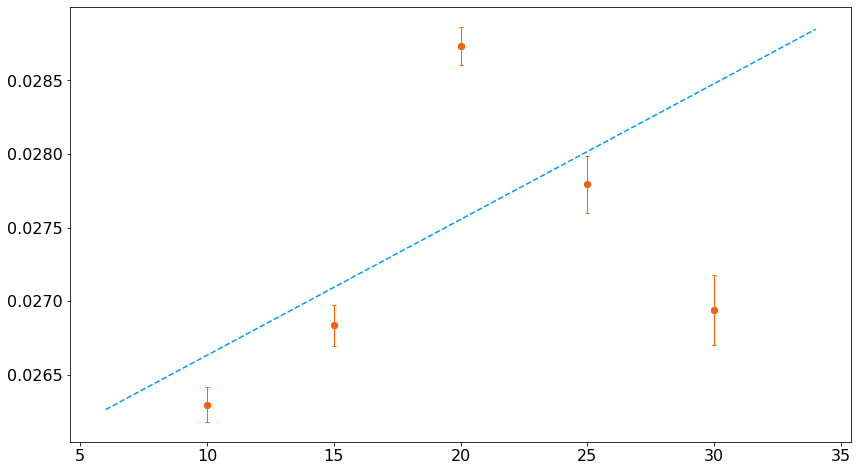

In [27]:
gauss_par, _ = curve_fit(
    f=lin,
    xdata=thetas, 
    ydata=gauss_up_peaks,
    sigma=gauss_up_err,
    absolute_sigma=True
)

fig, ax = plt.subplots()

theta_grid = np.linspace(thetas[0]-4, thetas[-1]+4, 500)
# ax.set_xlim(theta_grid[0], theta_grid[-1])

ax.scatter(
    thetas, gauss_up_peaks
)
ax.plot(
    theta_grid, 
    lin(theta_grid, *gauss_par),
    linestyle = "dashed",
    color = "#009cff", 
)
ax.errorbar(
    x          = thetas, 
    y          = gauss_up_peaks,
    yerr       = gauss_up_err,
    marker     = "o",
    color      =  "#ff6300",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ > x"
)

high_r, high_p = scipy.stats.pearsonr(thetas, gauss_up_peaks)
# high_r, high_p = scipy.stats.pearsonr(thetas, gauss_up_peaks)

print(f"Correlation coefficient {high_r:.5f}")
print(f"p-value = {high_p:.2e}")
print("Statistically significant:", "YES" if high_p < alpha else "NO")

In [ ]:
# # thetas_low = [0,10,20,30]
# # thetas_up = [10,20,30,40]
# # thetas_low = [0,5,10,15,20,25,30,35]
# # thetas_up = [5,10,15,20,25,30,35,40]

# # middle_cut = [ ( (np.abs(df["theta"]) > low ) & (np.abs(df["theta"]) < up ) ) for low,up in zip(thetas_low,thetas_up) ]

# gauss_middle_peaks = []
# gauss_middle_err = []

# fig, ax = plt.subplots(figsize=(15,8))

# for cut in middle_cut:
#     df_prova = df[ cut ]
#     p, b = np.histogram(df_prova.drift_time, bins=bins)
#     p_norm = normalize(p)
#     bin_centers = (b[1:]+b[:-1])/2

#     #incertezze sulle y cioè sulle probabilità:
#     norm = sum(p)
#     err = [np.sqrt(h / norm) for h in p_norm] #errore su tutti i p

#     DF = pd.DataFrame({'prob':p_norm, 'bin_cent':bin_centers, 'err':err})
#     DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
#     DF = DF.reset_index(drop=True)

#     prob_peak = DF['prob'].max()
#     bin_peak = DF['bin_cent'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]
#     err_peak = DF['err'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]

#     first_half_df = DF.loc[DF['bin_cent'] < bin_peak]
#     prob_first_half =  first_half_df['prob']
#     err_first_half = first_half_df['err']

#     bin_cent = DF['bin_cent'][(len(first_half_df)+1) : (2*len(first_half_df) +1) ].reset_index(drop=True)

#     second_half_df = pd.concat([prob_first_half, bin_cent, err_first_half], axis=1, ignore_index=True)
#     second_half_df.columns = ['prob', 'bin_cent', 'err']
#     second_half_df['prob'] = second_half_df['prob'].values[::-1]
#     second_half_df['err'] = second_half_df['err'].values[::-1]

#     first_half_df = first_half_df.append({'prob':prob_peak, 'bin_cent':bin_peak, 'err':err_peak}, ignore_index=True)
#     final_df = first_half_df.append(second_half_df, ignore_index=True)
#     final_df = final_df[ final_df['prob']!=0 ]
    
#     popt_gauss, covar = curve_fit(gaussian, final_df['bin_cent'], final_df['prob'], 
#     p0=[0.02, 20, 10], 
#     sigma=final_df['err'], 
#     absolute_sigma=True
#     )
#     # popt_lor, _ = curve_fit(lorentzian, final_df['bin_cent'], final_df['prob'], p0=[0.02, 20, 10])

#     y_gauss = gaussian(xx,*popt_gauss)
#     gauss_middle_peaks.append( y_gauss.max() )

#     sigma = np.sqrt(np.diagonal(covar)) #array con i 3 errori sui 3 parametri stimati da curve fit
#     #di questi prendiamo solo il primo errore che è quello commesso sullo scale parameter (picco)
#     gauss_middle_err.append(sigma[0])
#     ax.plot(xx, gaussian(xx,*popt_gauss), linewidth=1, label='gaussian')
#     ax.scatter(DF['bin_cent'], DF['prob'])

#     break

# for h, theta_low, theta_up in zip(middle_norm_hist, thetas_low,thetas_up,):
#     ax.hist(
#         bins[:-1],
#         bins=bins,
#         weights=h,
#         histtype="step",
#         linewidth = 2,
#         label=str(theta_low)+" "+ r"< $\theta$ < "+str(theta_up)+"°"
#     )
#     # ax.scatter(final_df['bin_cent'], final_df['prob'])

#     break
# ax.legend()

# # for p,e in zip(gauss_low_peaks, gauss_low_err):
# #     print(f'{p:.5f} pm {e:.5f}')


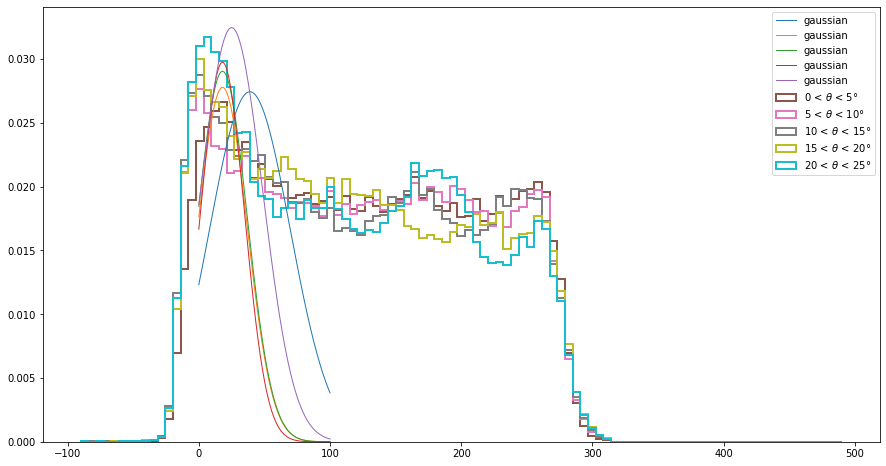

In [ ]:
gauss_middle_peaks = []
gauss_middle_err = []

fig, ax = plt.subplots(figsize=(15,8))

for p,b,err in zip(middle_norm_hist, middle_hist_bins, middle_err ):
    
    bin_centers = (b[1:]+b[:-1])/2

    DF = pd.DataFrame({'prob':p, 'bin_cent':bin_centers, 'err':err})
    DF = DF[ (DF['bin_cent'] > 0) & (DF['bin_cent'] <97)  ]
    DF = DF.reset_index(drop=True)

    prob_peak = DF['prob'].max()
    bin_peak = DF['bin_cent'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]
    err_peak = DF['err'][DF[DF['prob'] == prob_peak].index.tolist()].tolist()[0]

    first_half_df = DF.loc[DF['bin_cent'] < bin_peak]
    prob_first_half =  first_half_df['prob']
    err_first_half = first_half_df['err']

    bin_cent = DF['bin_cent'][(len(first_half_df)+1) : (2*len(first_half_df) +1) ].reset_index(drop=True)

    second_half_df = pd.concat([prob_first_half, bin_cent, err_first_half], axis=1, ignore_index=True)
    second_half_df.columns = ['prob', 'bin_cent', 'err']
    second_half_df['prob'] = second_half_df['prob'].values[::-1]
    second_half_df['err'] = second_half_df['err'].values[::-1]

    first_half_df = first_half_df.append({'prob':prob_peak, 'bin_cent':bin_peak, 'err':err_peak}, ignore_index=True)
    final_df = first_half_df.append(second_half_df, ignore_index=True)
    final_df = final_df[ final_df['prob']!=0 ]
    
    popt_gauss, covar = curve_fit(gaussian, final_df['bin_cent'], final_df['prob'], 
    p0=[ prob_peak , bin_peak, 10], 
    sigma=final_df['err'], 
    absolute_sigma=True
    )
    # popt_lor, _ = curve_fit(lorentzian, final_df['bin_cent'], final_df['prob'], p0=[0.02, 20, 10])

    y_gauss = gaussian(xx,*popt_gauss)
    gauss_middle_peaks.append( y_gauss.max() )

    sigma = np.sqrt(np.diagonal(covar)) #array con i 3 errori sui 3 parametri stimati da curve fit
    #di questi prendiamo solo il primo errore che è quello commesso sullo scale parameter (picco)
    gauss_middle_err.append(sigma[0])
    ax.plot(xx, gaussian(xx,*popt_gauss), linewidth=1, label='gaussian')
    
    # ax.scatter(DF['bin_cent'], DF['prob'])
    # break

for h, theta_low, theta_up in zip(middle_norm_hist, thetas_low, thetas_up,):
    ax.hist(
        bins[:-1],
        bins=bins,
        weights=h,
        histtype="step",
        linewidth = 2,
        label=str(theta_low)+" "+ r"< $\theta$ < "+str(theta_up)+"°"
    )
    # ax.scatter(final_df['bin_cent'], final_df['prob'])
    # break
ax.legend()



Correlation coefficient 0.94862
p-value = 0.0139
Statistically significant: YES


array([0.00063799, 0.10857649, 0.02680741])

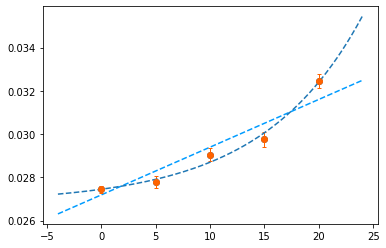

In [ ]:
gauss_par, _ = curve_fit(
    f=lin,
    xdata=thetas_low, 
    ydata=gauss_middle_peaks,
    sigma=gauss_middle_err,
    absolute_sigma=True
)

fig, ax = plt.subplots()

theta_grid = np.linspace(thetas_low[0]-4, thetas_low[-1]+4, 500)
# ax.set_xlim(theta_grid[0], theta_grid[-1])

ax.scatter(
    thetas_low, gauss_middle_peaks
)
ax.plot(
    theta_grid, 
    lin(theta_grid, *gauss_par),
    linestyle = "dashed",
    color = "#009cff", 
)
ax.errorbar(
    x          = thetas_low, 
    y          = gauss_middle_peaks,
    yerr       = gauss_middle_err,
    marker     = "o",
    color      =  "#ff6300",
    linestyle  = "none",
    elinewidth = 1, 
    capsize    = 2, 
    label      = r"cut: $\theta$ > x"
)

def expo(x, A, B, C):
    return A*np.exp(B*x) + C

exp_par,_ = curve_fit(
    f=expo,
    xdata=thetas_low, 
    ydata=gauss_middle_peaks,
    sigma=gauss_middle_err,
    absolute_sigma=True
)

ax.plot(
    theta_grid,
    expo(theta_grid, *exp_par),
    linestyle = "dashed",
)

high_r, high_p = scipy.stats.pearsonr(thetas_low, gauss_middle_peaks)
# high_r, high_p = scipy.stats.pearsonr(thetas, gauss_up_peaks)

print(f"Correlation coefficient {high_r:.5f}")
print(f"p-value = {high_p:.4f}")
print("Statistically significant:", "YES" if high_p < alpha else "NO")
exp_par